<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
# Necessário para o modelo Transformer
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as tf_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 42.5 MB/s eta 0:00:00


## Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [4]:
SEMENTE = 42

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 8

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 128
NUCLEO_CONV = 5
NUCLEO_SAIDA = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.0005
METRICAS    = ['accuracy']

ITERACOES = 3
ITERACOES_MLP = 20

## Dados

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [6]:
dados = dados[dados['noticias'].notna()]

In [7]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [9]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [10]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [11]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE, stratify=y_train_val)

### Converter texto em números

In [12]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [13]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [14]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [15]:
vetorizador.adapt(X)

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
# len(vocabulario), vocabulario[:10], vocabulario[-10:]

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

## Funções

In [19]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelos_nome[modelo_numero])

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acurácia': relatorio['accuracy'],
            'precisão': relatorio['weighted avg']['precision'],
            'revocação': relatorio['weighted avg']['recall'],
            'pontuação-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])

def teste_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [20]:
modelos_nome = [None] * MAXIMO_MODELOS

modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [21]:
%%time

modelo_numero = 0

modelos_nome[modelo_numero] = 'TF-IDF'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

CPU times: user 1.73 s, sys: 20.6 ms, total: 1.75 s
Wall time: 1.85 s


Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1103
           1       0.60      0.79      0.68       830

    accuracy                           0.68      1933
   macro avg       0.69      0.69      0.68      1933
weighted avg       0.71      0.68      0.68      1933



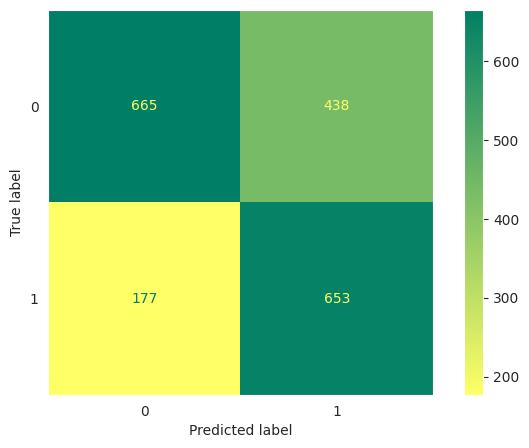

In [23]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [24]:
relatorios[modelo_numero]

{'acurácia': 0.6818416968442835,
 'precisão': 0.7076652728288632,
 'revocação': 0.6818416968442835,
 'pontuação-f1': 0.6821083937915633}

### Camadas iniciais padronizadas

In [25]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 70.5 ms, sys: 3 ms, total: 73.5 ms
Wall time: 102 ms


### Modelo 1: MLP

In [26]:
%%time

modelo_numero = 1

modelos_nome[modelo_numero] = 'MLP'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES_MLP,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/20
121/121 [==============================] - 40s 257ms/step - loss: 0.6674 - accuracy: 0.5944 - val_loss: 0.6416 - val_accuracy: 0.7600
Epoch 2/20
121/121 [==============================] - 24s 199ms/step - loss: 0.6024 - accuracy: 0.8600 - val_loss: 0.5673 - val_accuracy: 0.8681
Epoch 3/20
121/121 [==============================] - 23s 191ms/step - loss: 0.5134 - accuracy: 0.8717 - val_loss: 0.4876 - val_accuracy: 0.8634
Epoch 4/20
121/121 [==============================] - 24s 200ms/step - loss: 0.4279 - accuracy: 0.8757 - val_loss: 0.4236 - val_accuracy: 0.8660
Epoch 5/20
121/121 [==============================] - 24s 195ms/step - loss: 0.3577 - accuracy: 0.8798 - val_loss: 0.3750 - val_accuracy: 0.8686
Epoch 6/20
121/121 [==============================] - 21s 175ms/step - loss: 0.3015 - accuracy: 0.8889 - val_loss: 0.3396 - val_accuracy: 0.8733
Epoch 7/20
121/121 [==============================] - 21s 173ms/step - loss: 0.2557 - accuracy: 0.9069 - val_loss: 0.3126 - val_ac

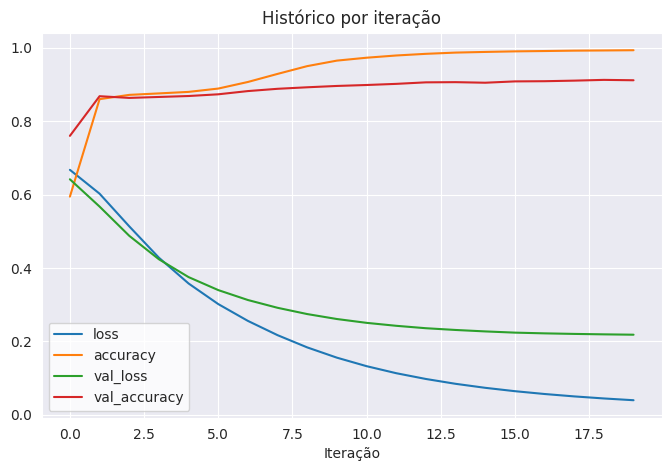

In [27]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1103
           1       0.93      0.85      0.89       830

    accuracy                           0.91      1933
   macro avg       0.92      0.90      0.91      1933
weighted avg       0.91      0.91      0.91      1933



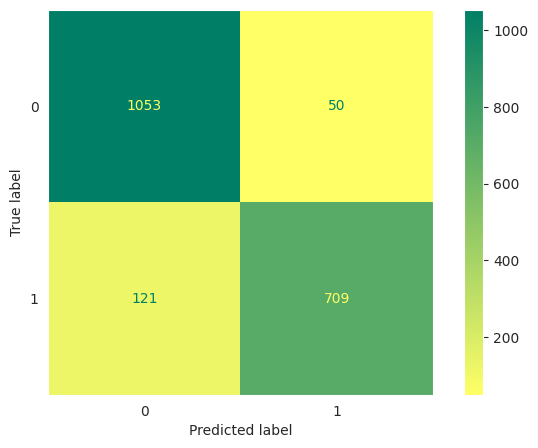

In [28]:
dados_modelo(modelo_numero)

In [29]:
relatorios[modelo_numero]

{'acurácia': 0.9115364718054837,
 'precisão': 0.9129024885437211,
 'revocação': 0.9115364718054837,
 'pontuação-f1': 0.9109393071160351}

### Modelo 2: CNN

In [30]:
%%time

modelo_numero = 2

modelos_nome[modelo_numero] = 'RNC'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 30s 198ms/step - loss: 0.5416 - accuracy: 0.7773 - val_loss: 0.4276 - val_accuracy: 0.8551
Epoch 2/3
121/121 [==============================] - 21s 172ms/step - loss: 0.2523 - accuracy: 0.9243 - val_loss: 0.2995 - val_accuracy: 0.8815
Epoch 3/3
121/121 [==============================] - 22s 182ms/step - loss: 0.1053 - accuracy: 0.9744 - val_loss: 0.2774 - val_accuracy: 0.8852
CPU times: user 58.7 s, sys: 1.46 s, total: 1min
Wall time: 1min 13s


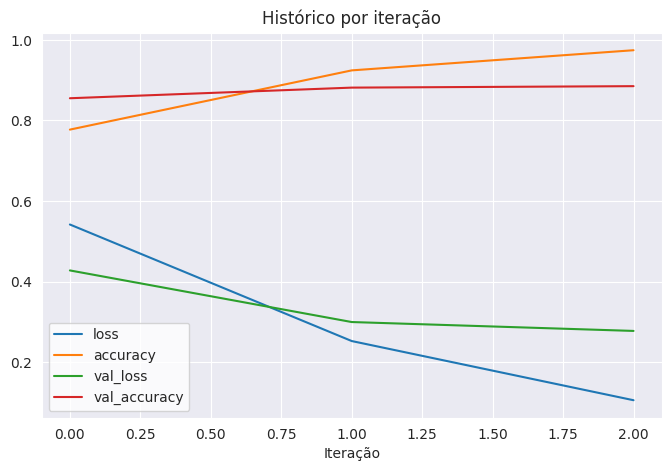

In [31]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1103
           1       0.86      0.88      0.87       830

    accuracy                           0.89      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.89      0.89      0.89      1933



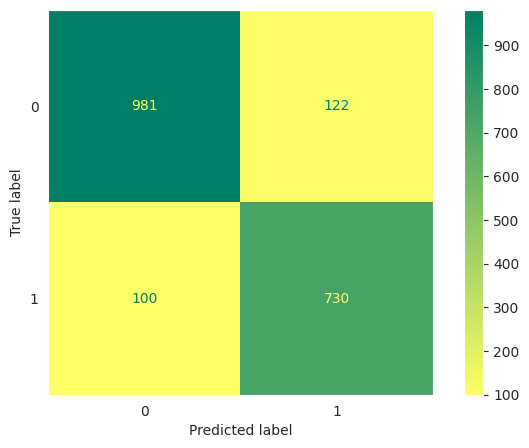

In [32]:
dados_modelo(modelo_numero)

In [33]:
relatorios[modelo_numero]

{'acurácia': 0.8851526125193999,
 'precisão': 0.8857294785852748,
 'revocação': 0.8851526125193999,
 'pontuação-f1': 0.8853252515136385}

### Modelo 3: DCNN

In [34]:
%%time

modelo_numero = 3

modelos_nome[modelo_numero] = 'CFN-AI'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 28s 207ms/step - loss: 0.1764 - accuracy: 0.9393 - val_loss: 0.3394 - val_accuracy: 0.8846
Epoch 2/3
121/121 [==============================] - 24s 198ms/step - loss: 0.0234 - accuracy: 0.9915 - val_loss: 0.3775 - val_accuracy: 0.8888
Epoch 3/3
121/121 [==============================] - 21s 176ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.4436 - val_accuracy: 0.8831
CPU times: user 1min 1s, sys: 1.12 s, total: 1min 2s
Wall time: 1min 13s


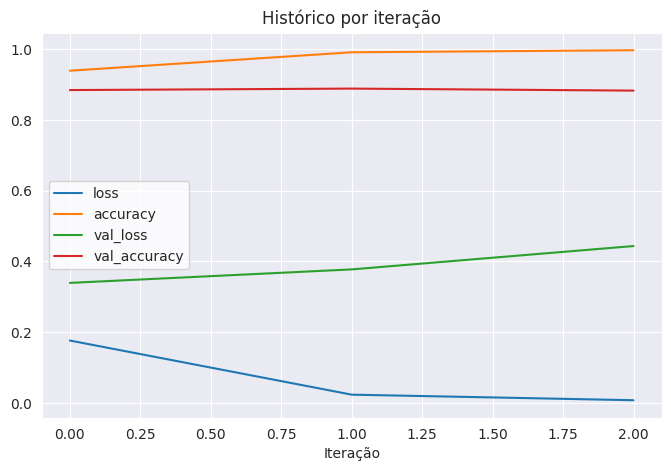

In [35]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1103
           1       0.83      0.91      0.87       830

    accuracy                           0.88      1933
   macro avg       0.88      0.89      0.88      1933
weighted avg       0.89      0.88      0.88      1933



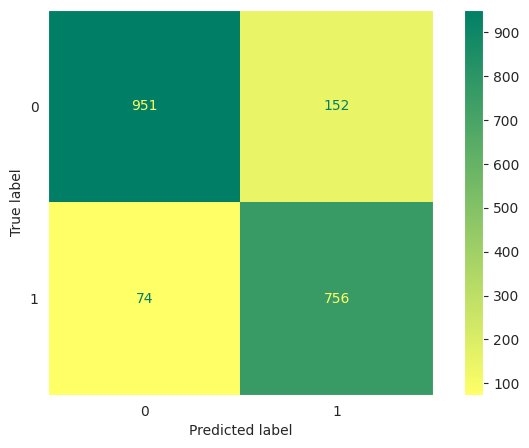

In [36]:
dados_modelo(modelo_numero)

In [37]:
relatorios[modelo_numero]

{'acurácia': 0.8830832902224521,
 'precisão': 0.8869250125247139,
 'revocação': 0.8830832902224521,
 'pontuação-f1': 0.8835641123031095}

### Modelo 4: RNN (LSTM Bidirecional)

In [38]:
%%time

modelo_numero = 4

modelos_nome[modelo_numero] = 'RNR'

camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 40s 296ms/step - loss: 0.3790 - accuracy: 0.8322 - val_loss: 0.2775 - val_accuracy: 0.8945
Epoch 2/3
121/121 [==============================] - 34s 282ms/step - loss: 0.1237 - accuracy: 0.9629 - val_loss: 0.3376 - val_accuracy: 0.8536
Epoch 3/3
121/121 [==============================] - 32s 267ms/step - loss: 0.0506 - accuracy: 0.9859 - val_loss: 0.3028 - val_accuracy: 0.9017
CPU times: user 1min 33s, sys: 3.48 s, total: 1min 36s
Wall time: 2min 25s


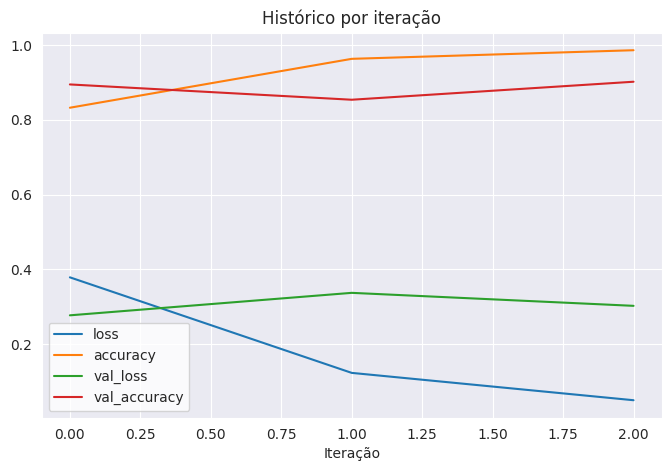

In [39]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 3s 34ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1103
           1       0.88      0.90      0.89       830

    accuracy                           0.90      1933
   macro avg       0.90      0.90      0.90      1933
weighted avg       0.90      0.90      0.90      1933



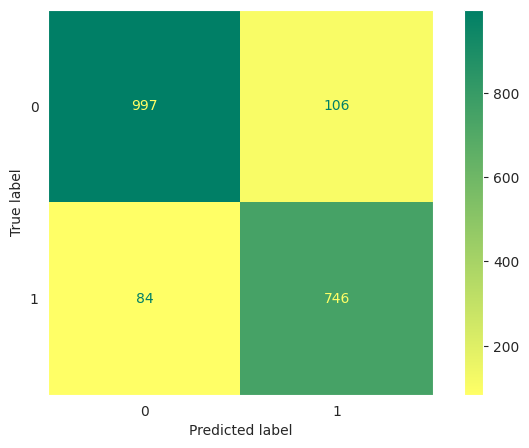

In [40]:
dados_modelo(modelo_numero)

In [41]:
relatorios[modelo_numero]

{'acurácia': 0.9017071908949819,
 'precisão': 0.9022387796105856,
 'revocação': 0.9017071908949819,
 'pontuação-f1': 0.9018549449891501}

### Modelo 5: Transformer

In [42]:
%%time

modelo_numero = 5

modelos_nome[modelo_numero] = 'Transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 80s 541ms/step - loss: 0.6021 - accuracy: 0.6774 - val_loss: 0.4991 - val_accuracy: 0.7584
Epoch 2/3
121/121 [==============================] - 59s 490ms/step - loss: 0.4352 - accuracy: 0.7968 - val_loss: 0.4157 - val_accuracy: 0.8081
Epoch 3/3
121/121 [==============================] - 55s 456ms/step - loss: 0.3054 - accuracy: 0.8600 - val_loss: 0.4494 - val_accuracy: 0.8050
CPU times: user 3min 32s, sys: 19.4 s, total: 3min 51s
Wall time: 3min 41s


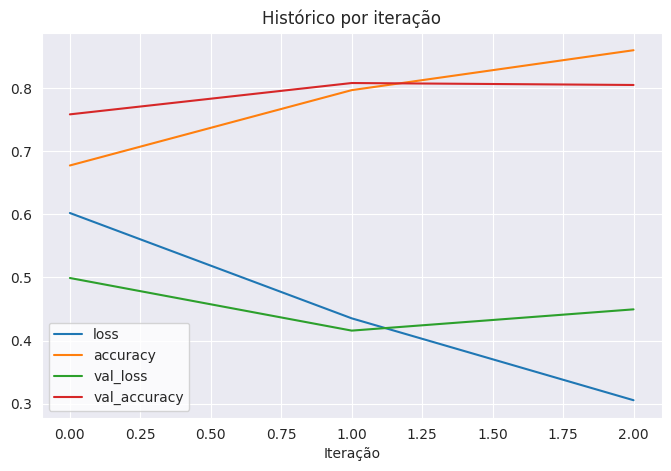

In [43]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 8s 125ms/step
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1103
           1       0.76      0.80      0.78       830

    accuracy                           0.80      1933
   macro avg       0.80      0.80      0.80      1933
weighted avg       0.81      0.80      0.81      1933



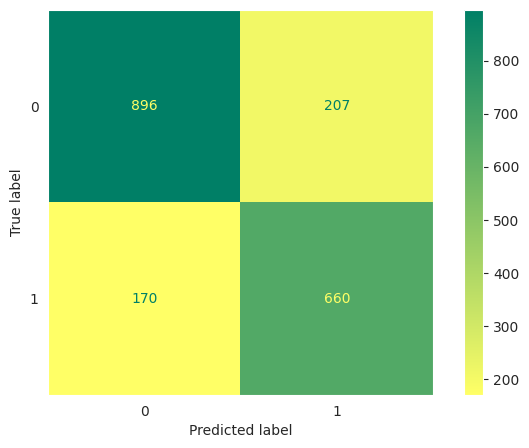

In [44]:
dados_modelo(modelo_numero)

In [45]:
relatorios[modelo_numero]

{'acurácia': 0.8049663735126746,
 'precisão': 0.8064838836951992,
 'revocação': 0.8049663735126746,
 'pontuação-f1': 0.8054290546866735}

### Modelo 6: fakeDETECTOR

In [46]:
%%time

modelo_numero = 6

modelos_nome[modelo_numero] = 'fakeD'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

camadas = Dense(ESPACO_SAIDA, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 24s 187ms/step - loss: 0.1967 - accuracy: 0.9455 - val_loss: 0.3248 - val_accuracy: 0.8903
Epoch 2/3
121/121 [==============================] - 21s 175ms/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.3665 - val_accuracy: 0.8893
Epoch 3/3
121/121 [==============================] - 21s 176ms/step - loss: 0.0068 - accuracy: 0.9969 - val_loss: 0.4130 - val_accuracy: 0.8836
CPU times: user 57.7 s, sys: 947 ms, total: 58.7 s
Wall time: 1min 22s


In [47]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1103
           1       0.85      0.89      0.87       830

    accuracy                           0.88      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.88      0.88      0.88      1933



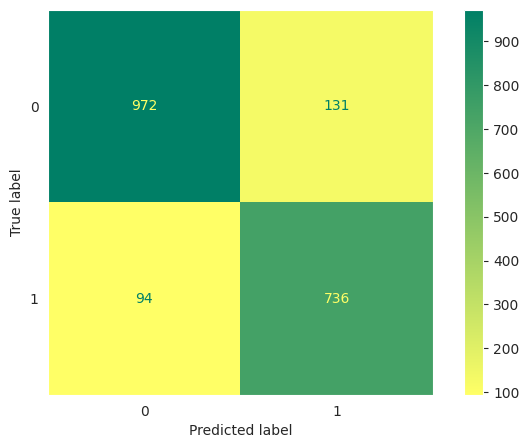

In [48]:
dados_modelo(modelo_numero)

In [49]:
relatorios[modelo_numero]

{'acurácia': 0.8836006207966891,
 'precisão': 0.8848049032250851,
 'revocação': 0.8836006207966891,
 'pontuação-f1': 0.8838767567758663}

### Modelo 7: fakeDETECTOR HDF5

In [50]:
%%time

modelo_numero = 7

modelos_nome[modelo_numero] = 'fakeD-H5'

modelos[modelo_numero] = tf.keras.models.load_model('fakeDETECTOR_HDF5.h5')

CPU times: user 309 ms, sys: 454 ms, total: 762 ms
Wall time: 757 ms


In [51]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [59]:
modelos[6].summary()

Model: "fakeD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_entrada (InputLayer  [(None, 1)]               0         
 )                                                               
                                                                 
 text_vectorization (TextVe  (None, 1453)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1453, 128)         11520000  
                                                                 
 camada_convulacional (Conv  (None, 1453, 128)         82048     
 1D)                                                             
                                                                 
 agrupamento_maximo_global   (None, 128)               0         
 (GlobalMaxPooling1D)                                        

In [58]:
modelos[7].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         14709200  
                                                                 
 conv1d (Conv1D)             (None, 996, 256)          256256    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15031505 (57.34 MB)
Trainable params: 15031505 (57.34 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [57]:
modelos[7].evaluate(X_val, y_val)

ValueError: ignored

In [ ]:
dados_modelo(modelo_numero)

In [ ]:
relatorios[modelo_numero]

## Comparar modelos

In [ ]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

In [ ]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

# plt.title('Medidas de avaliação dos modelos - Dados de validação')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));

## Teste modelos

In [ ]:
# avaliacoes     = [None] * MAXIMO_MODELOS
# probabilidades = [None] * MAXIMO_MODELOS
# previsoes      = [None] * MAXIMO_MODELOS
# relatorios     = [None] * MAXIMO_MODELOS

In [ ]:
# for modelo_numero, modelo in enumerate(modelos):
#     teste_modelo(modelo_numero)
#     print(relatorios[modelo_numero])

In [ ]:
# comparacao = pd.DataFrame([r for r in relatorios if r is not None])
# comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

In [ ]:
# sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

# plt.ylim(0.0, 1.0)

# # plt.title('Medidas de avaliação dos modelos - Dados de teste')
# plt.xlabel('Modelos')
# plt.ylabel('Valor')

# plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
# plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

# plt.legend(loc=(1.03, 0.76));